# MAIN
This is the master notebook for my AirBnB Recruiting Challenge work. Changes and additions are made by branching and merging.

Other possible branches:
* Explore
* Prepocessing
* Features
* Models
* Multiclass
* Imbalance
* Validation
* Ensembels
* Imputation
* Test
* PCA


## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("whitegrid") #, {'ytick.major.size': 10.0})
#sns.set_context("talk")

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Get Data

In [2]:
# Load data into DataFrames
train_users = pd.read_csv('input/train_users_2.csv')
test_users = pd.read_csv('input/test_users.csv')

piv_train = train_users.shape[0]
labels = train_users['country_destination'].values


all_users = pd.concat([train_users,test_users],axis=0,ignore_index=True)

## Measure: NDCG

In [3]:
from rank_metrics import ndcg_at_k
from sklearn.metrics import make_scorer

def ndcg_wrapper(y_true,y_pred_proba):
    
    Y = np.fliplr(y_pred_proba.argsort())
        
    R = []
    NDCG = []
    for i in range(0,y_true.size):
        r = (Y[i,:]==y_true[i]).astype(int)
        R.append(r)
        #ndcg_at_k([0,0,1],5,method=1)
        NDCG.append(ndcg_at_k(r,5,method=1))
    
    #print(NDCG)
    #return NDCG,R
    return np.mean(NDCG)

ndcg_scorer = make_scorer(ndcg_wrapper, greater_is_better=True, needs_proba=True)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#  Features 

## Preprocessing of Main Features

In [4]:
def preprocess_missing(df):
    ##AGE
    
    ## DISCRETIZE AGE
    A = pd.cut(df['age'],list(range(14,100,5)),right=True)
    A = pd.get_dummies(A)
    df= pd.concat([df,A],axis=1)
    
    #Remove all ages outside of range, set to -1 for separate categorisation //impute for logistic regression
    df.loc[df.age > 100, 'age'] = np.nan
    df.loc[df.age < 15, 'age'] = np.nan
    df['age'].fillna(-111,inplace=True)

    ## GENDER
    # Set missing values to own category
    df['gender'].replace('-unknown-',np.nan, inplace=True)
    #df['gender'].fillna('MISSING',inplace=True)

    ## FIRST AFFILIATE TRACKED
    # Set missing to untracked, hopefully the same
    df['first_affiliate_tracked'].fillna('untracked',inplace=True)
    
    ## Get rid of date_first_booking
    if 'date_first_booking' in df.columns:
        df.drop(['date_first_booking'],axis=1,inplace=True)
    
    return df

def preprocess_features(df):
    ## dates
    
    # date_account_created
    dac = np.vstack(df.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
    df['dac_year'] = dac[:,0]
    df['dac_month'] = dac[:,1]
    df['dac_day'] = dac[:,2]
    df.drop(['date_account_created'],axis=1,inplace=True)
    
    #time first active
    tfa = np.vstack(df.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
    df['tfa_year'] = tfa[:,0]
    df['tfa_month'] = tfa[:,1]
    df['tfa_day'] = tfa[:,2]
    df['tfa_hour'] = tfa[:,3]
    df.drop(['timestamp_first_active'],axis=1,inplace=True)
    
    
    ## One-Hot Encoding
    categorical_features = ['affiliate_channel','affiliate_provider','first_affiliate_tracked',
                            'first_browser','first_device_type','gender','language','signup_app','signup_flow','signup_method'
                           ]
    
    df = pd.get_dummies(df,columns=categorical_features)
    
    return df

def preprocess_all(df):

    df_p = preprocess_missing(df)
    df_p = preprocess_features(df_p)
    
    return(df_p)

In [5]:
All = preprocess_all(all_users) 

## Session Features

In [6]:
session_df = pd.read_csv('input/sessions.csv')

#### Counts of Actions Taken

In [7]:
session_users = session_df

# Clean missing values
session_users['secs_elapsed'].fillna(0,inplace=True)
session_users['action_type'].fillna('',inplace=True)

# Combine for grouping
#session_users['action_action_type'] = session_users['action']+'__'+session_users['action_type']
session_users['action_action_detail'] = session_users['action']+'__'+session_users['action_detail']
#session_users['action_action_type_detail'] = session_users['action']+'__'+session_users['action_type']+'__'+session_users['action_detail']


# Group actions for users
#session_users1 = session_users.groupby(['user_id','action_action_type']).count()['secs_elapsed'].unstack().fillna(0)
session_users2 = session_users.groupby(['user_id','action_action_detail']).count()['secs_elapsed'].unstack().fillna(0)
#session_users3 = session_users.groupby(['user_id','action_action_type_detail']).count()['secs_elapsed'].unstack().fillna(0)


In [8]:
#session_users2.head(2)

#### Elapsed Time by Device Type

In [9]:
deviceusage_df = session_df[['user_id','device_type','secs_elapsed']].groupby(['user_id','device_type']).sum().unstack()['secs_elapsed']
deviceusage_df.fillna(0,inplace=True)
#deviceusage_df.head(2)

#### Combine Extracted Features

In [10]:
SessionFeatures = pd.merge(session_users2,deviceusage_df,right_index=True,left_index=True,how='inner')

#### Session Feature Selection

In [11]:
k = 150

#Need to use labelled to select
SessionX = pd.merge(train_users[['id','country_destination']],SessionFeatures,right_index=True,left_on='id',how='inner')
Sessiony = SessionX['country_destination']
SessionX.drop(['id','country_destination'],axis=1,inplace=True)

test_users2 = 

In [12]:
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(k=150)
selector.fit(SessionX,Sessiony)
SessionFeatures = SessionFeatures[SessionFeatures.columns[selector.get_support()]]

c:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  5   7  10  12  15  16  63  65  80  82  83  84  85  89  90  92 114 124
 127 131 135 136 141 154 171 179 188 196 197 198 199 200 201 203 239 258
 259 319 324 332 334 335 339 343 348 349 360 362 378 383 386 390 393 411
 427] are constant.
  UserWarning)


## Age_Gender_Bkts - Create Features
Could also add in Country Locations here . . . if that makes a difference.

In [13]:
age_gender_df = pd.read_csv('input/age_gender_bkts.csv')

In [14]:
A = pd.pivot_table(age_gender_df,values='population_in_thousands',index=['age_bucket','gender'],columns='country_destination')
normalised_brackets = A.divide(A.sum(axis=1),axis=0)
normalised_totals = A.sum()/A.sum().sum()
#normalised_brackets

In [15]:
#AA = A.reset_index().groupby('gender').sum()  ## - Later separate missing by male and female . . . very sligth difference?
#AA.loc['female']/AA.loc['male']

In [16]:
def age_bucket_converter(age, gender):
    
    
    if (age>0)&(age<100):
        a = int((age//5)*5)
        Age = str(a)+'-'+str(a+4)
        if Age == '5-9': Age = 'Missing'
        
    elif age>99: Age = '100+'
    else: Age = 'Missing'
        
    if gender == 'MALE': Gender = 'male'
    elif gender == 'FEMALE': Gender = 'female'
    else: Gender = 'Missing'
    
    return (Age, Gender)

def bkts_feature_create(age_gender,normalised_brackets,normalised_totals):
     
    Age,Gender = age_bucket_converter(*age_gender)
    #print([Age,Gender])
    
    if ((Age=='Missing')|(Gender=='Missing')):
        return normalised_totals
    else:
        return normalised_brackets.loc[(Age,Gender)]

##### Create Features

In [17]:
BracketFeatures = all_users[['age','gender']].apply(lambda x: bkts_feature_create(tuple(x.values),normalised_brackets,normalised_totals),axis=1)
BracketFeatures.set_index(all_users['id'],inplace=True)

## SELECT AND COMBINE FEATURES

In [18]:
## Merge with Bracket Features
All = All.merge(BracketFeatures,how='inner',left_on='id',right_index=True) 

## Merge with Session Features
All = All.merge(SessionFeatures,how='inner',left_on='id',right_index=True)

print('num users total = ',All.shape[0])
print('num features = ',All.shape[1])

# Reattach Ids
#All['id'] = all_users['id']
#X = X.merge(SessionFeatures,how='inner',left_on='id',right_index=True) 

num users total =  135038
num features =  339


## SELECT TRAINING EXAMPLES - Which classes?

In [55]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#included_destinations = ['NDF','US']
included_destinations = ['NDF','US','FR','IT','other']

X  = All[All['country_destination'].apply(lambda x: x in included_destinations)]
y = le.fit_transform(X['country_destination'])

X = X.drop(['country_destination','id'],axis=1)

X_Test = All[All['country_destination'].isnull()].drop(['country_destination','id'],axis=1)
X_Test_ids = All[All['country_destination'].isnull()]['id']

print(list(zip(le.classes_,range(0,len(y)))))

[('FR', 0), ('IT', 1), ('NDF', 2), ('US', 3), ('other', 4)]


# MODELS

In [21]:
#Imports
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import preprocessing


### 0. Dummy Estimator

In [22]:
## Compare with basic. If you can't beat this, there's a probelm.

from sklearn.dummy import DummyClassifier
Dummy = DummyClassifier(strategy='prior').fit(X,y)
dummy_score = ndcg_scorer(Dummy,X,y)
dummy_score

0.85031379146898278

### 1. Logistic Regression
Logistic Regression without Grid Search on gets CrossVal of 0.657, which is a mild improvement over 0.583 for setting all NDF. Balancing classes brings it down negligably to 0.646
Grid search doesn't seemed to have helped - 0.658 with C of 11.94
After scaling age, this now appears third largest among the coefficients, though seemingly a decrease in accuracy to 0.63

Discretizing age has increased the score to 0.667, on 1% up. It's something.But none of the age variables features in important coefficients.
Reintoducing age as continuous (with NaNs imputed) together with discrete , brings things now up to 0.675. Huh

Interesting. The score on the training data is almost the same. So we might not be overfitting and just have too high bias.

And now the age brackets are appearing in the coeffs. How very strange. Seems that having entered your age validly correlates with actually booking. Now gender isn't showing up though. Could there just be the single latent variable of "filling out the form properly?"

Next run of GridSearch gives ~5 for C, stronger regularisation, and a score of 0.688, which is several points up from when I started.

----------------- 

Changing now to multiclass, helps with developing NDCG.


In [ ]:

## Customise Train and Test for Logistic Regression

def lr_preprocess(X):
    # Accepts already processed X and y

    ## DISCRETIZE AGE
    #X_log = X # Create X just for Logistic Regression
    #A = pd.cut(X_log['age'],list(range(14,100,5)),right=True)
    #A = pd.get_dummies(A)
    #X_log= pd.concat([X_log,A],axis=1)
    #X_train.drop(['age'],axis=1,inplace=True)


    ## IMPUTE VALUES AND SCALE
    X['age'].replace(-1,np.median(X['age']),inplace=True)
    scaler = preprocessing.MinMaxScaler()
    X['age'] = scaler.fit_transform(X['age'])

    return X

In [ ]:
All_log = lr_preprocess(All)
All_log.shape

In [ ]:
#%%timeit -r1
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(Cs=5,class_weight='balanced') #class_weight='balanced'
clf.fit(X_log,y_log)


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C = 0.0045,class_weight='balanced')
print(np.mean(cross_val_score(clf,X_log,y_log,cv=5,scoring=ndcg_scorer)))

In [ ]:
#%%timeit -r1
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C = 0.0005,class_weight='balanced')

#Need to stratify.
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print('NDCG = ',ndcg_scorer(clf,X_test,y_test))
print('Accuracy = ',metrics.accuracy_score(y_test,y_pred))


In [ ]:
%%timeit
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C ,class_weight='balanced') #class_weight='balanced'
clf.fit(X_log,y_log)


In [ ]:
print('NDCG = ',ndcg_scorer(clf,X_test,y_test))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, random_state=0)
ndcg_scorer(clf,X_test,y_test)


In [ ]:
## Test for overfitting:
y_pred = clf.predict(X_train)
print('NDCG = ',ndcg_scorer(clf,X_train,y_train))
print('Accuracy = ',metrics.accuracy_score(y_train,y_pred))
print('Recall = ',metrics.recall_score(y_train,y_pred))
print('Precision = ',metrics.precision_score(y_train,y_pred))

### Grid Search

In [ ]:
Crange = np.logspace(-1,2,30)

grid = GridSearchCV(LogisticRegression(), param_grid={'C': Crange},scoring='accuracy',cv=3,n_jobs=4)
grid.fit(X_train,y_train)
print ("best parameter choice:", grid.best_params_)
print ("best score:", grid.best_score_)


### Feature Importances - Logistic Regression

In [ ]:
FeatureImportances = pd.DataFrame(data = { 'coefs': clf.coef_.squeeze(), 'abs coefs' : np.abs(clf.coef_.squeeze())},index=X_log.columns)
FeatureImportances.sort_values(by='abs coefs',ascending=False,inplace=True)

k = 50
plt.figure(figsize=(10,10))
sns.barplot(y=FeatureImportances.index[0:k],x=FeatureImportances['coefs'].head(k))
#plt.xticks(rotation = 90)

The picture I get from this that people are less likely to book from mobile devices. And more likely to book if they correctly filled out their from. I doubt logicst regression has handled the age feature well. Hence why discretizing might be a good idea.

## 2. Random Forest

### Notes

Very first attempt got 0.8449, which is negligibly higher than the dummy estimator at 0.84055

I'm confused, why does my simple train test split give 0.82 while the GridSearch gets a mere 0.75

Adding in session features seems to help a lot. First train-test split gives 0.8835. Hmm, note that that one isn't weighted.
0.879 with threefold cross validation. Looks good, gives a 3.1% improvement over dummy, which is something.

Looking at confusion matrix, everything is either US or NDF, never predict anything as Italy, France, or Other.

### Custom Preprocessing

In [ ]:
# Doesn't require any yet.

### Model

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=3)

In [ ]:
## Standalone
RF = RandomForestClassifier(oob_score=True,n_estimators=250,n_jobs=-1) #,class_weight='balanced')
RF.fit(X_train,y_train)
ypred = RF.predict(X_test)

clf = RF

ndcg_scorer(RF,X_test,y_test)

In [24]:
## GridSearch
RF = RandomForestClassifier(class_weight='balanced',oob_score=True)
gridRF = GridSearchCV(RF,param_grid={'n_estimators':[200],
                                   'max_features':[20,30]},
                      scoring=ndcg_scorer,cv=4)
gridRF.fit(X,y)

print(gridRF.best_params_)
print(gridRF.best_score_)

{'n_estimators': 200, 'max_features': 30}
0.881674283158


In [25]:
RF_best = gridRF.best_estimator_
RF_best

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=30,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [ ]:
np.sqrt(337)

In [37]:
gridRF.grid_scores_

[mean: 0.88096, std: 0.00159, params: {'n_estimators': 200, 'max_features': 20},
 mean: 0.88167, std: 0.00125, params: {'n_estimators': 200, 'max_features': 30}]

#### Scores and Confusion Matrix

In [ ]:
#dummy_score = ndcg_scorer(Dummy,X_test,y_test)
ndcg_score = ndcg_scorer(RF,X_test,y_test)
print('ndcg = ', ndcg_score)
print('dummy = ', dummy_score)
print('improvement over dummy: %3.3f%%' % ((ndcg_score - dummy_score)*100))

In [ ]:
classes = le.classes_

In [ ]:
sns.set_context("talk")
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('confusion matrix')
print(cm)

plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

In [ ]:
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred,target_names=le.classes_))
print('ndcg = ', ndcg_score)

### Feature Importance

In [28]:
clf = RF_best

In [29]:
FeatureImportances = pd.Series(index=X.columns,data=clf.feature_importances_).sort_values(ascending=False)

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


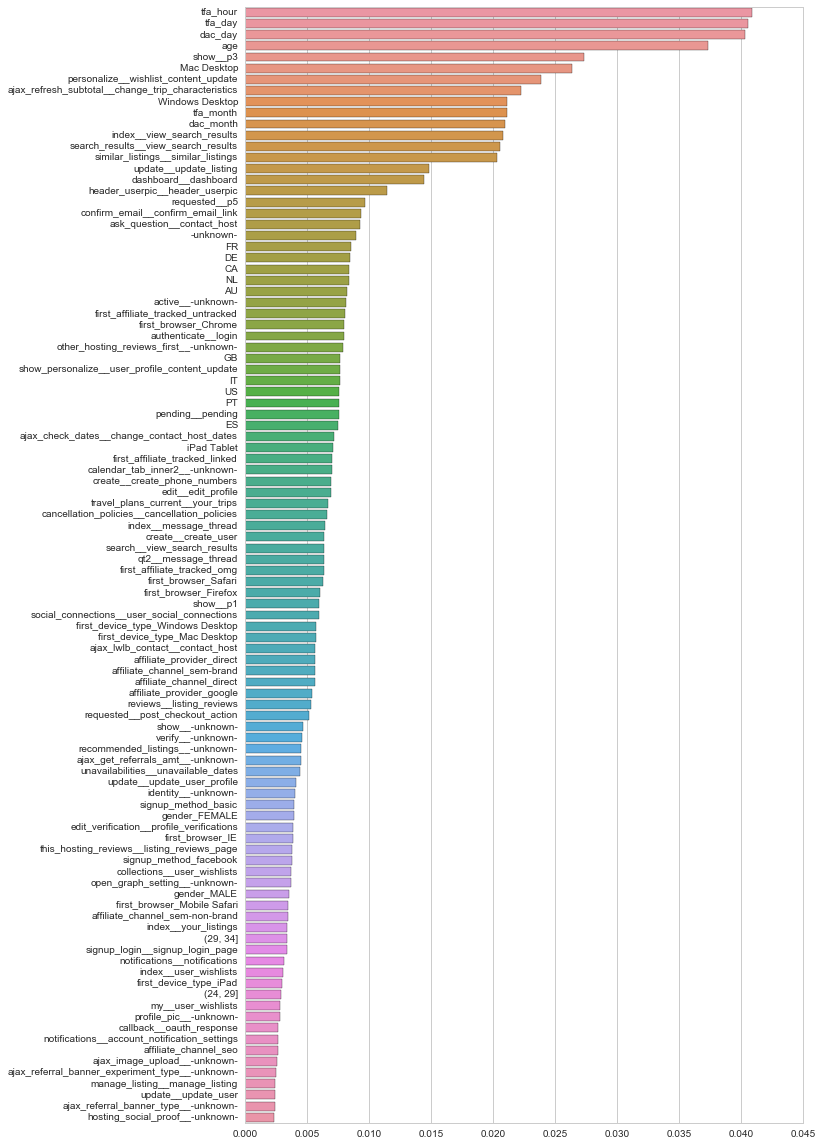

In [36]:
k = 100
plt.figure(figsize=(10,20))
sns.barplot(y=FeatureImportances.index[0:k],x=FeatureImportances.head(k))


In [ ]:
k = 100
plt.figure(figsize=(10,15))
sns.barplot(y=FeatureScores.index[0:k],x=FeatureScores.head(k))
#plt.xticks(rotation = 90)

### Validation and Learning Curve

In [72]:
from sklearn.learning_curve import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(clf, X, y,scoring=ndcg_scorer,train_sizes=[0.1,0.5,0.8,1])

In [ ]:
from plot_learning_curve import plot_learning_curve



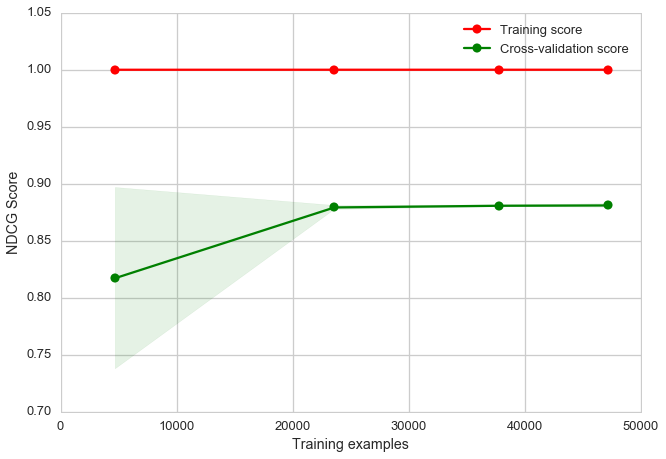

In [90]:
sns.set_style("whitegrid") #, {'ytick.major.size': 10.0})
sns.set_context("talk")

plt.figure()
#plt.title(title)
#if ylim is not None: plt.ylim((0.7,1.01)
#plt.xlabel = 'H'
plt.xlabel("Training examples")
plt.ylabel("NDCG Score")

#train_sizes, train_scores, test_scores = learning_curve(    estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)


plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.grid()


plt.grid()

In [79]:
train_sizes

array([ 4719, 23599, 37758, 47198])

In [91]:
from sklearn.learning_curve import validation_curve

train_scores, valid_scores = validation_curve(RandomForestClassifier(oob_score=True,n_jobs=-1,class_weight='balanced')
                                              , X, y, "n_estimators", [50,100,200,500],cv=2)

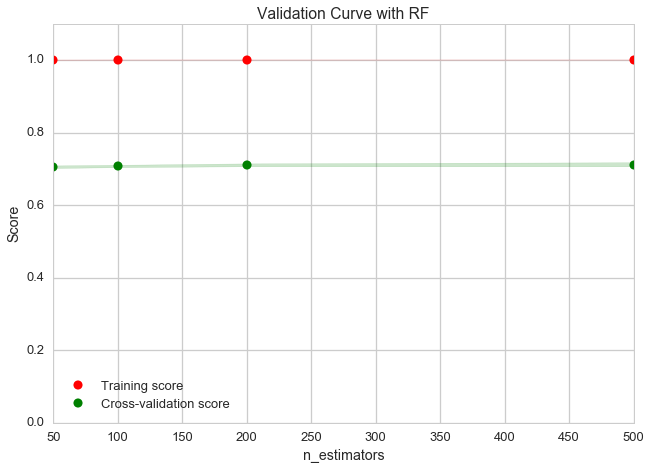

In [101]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

param_range = [50,100,200,500]

plt.title("Validation Curve with RF")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_scores_mean,'ro', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean,'go', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()


In [102]:
from sklearn.learning_curve import validation_curve

train_scores, valid_scores = validation_curve(RandomForestClassifier(n_jobs=-1,class_weight='balanced')
                                              , X, y, "max_features", [10,20,50],cv=2)

c:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\Anaconda3\lib\site-packages\sklea

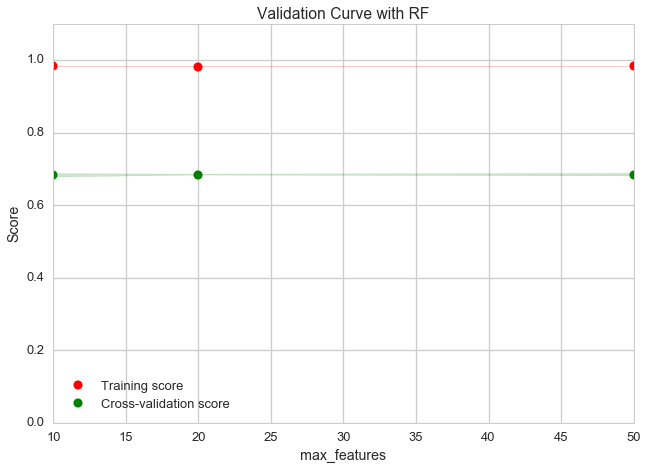

In [104]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

param_range = [10,20,50]

plt.title("Validation Curve with RF")
plt.xlabel("max_features")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_scores_mean,'ro', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean,'go', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()


## 3. ExtraTrees

## 4. XGBoost

# TEST-SET PREDICTIONS

In [49]:
def create_sub(preds,id_test):
##Format predictions for Kaggle online submission
    
    n = 5

    ids = [] # list of id's
    cts = [] # list of countries
    for i in range(len(id_test)):
        idx = id_test[i]
        ids += [idx]*n
        cts += list(preds[i][0:n])
    
    submission = pd.DataFrame(np.column_stack((ids,cts)), columns=['id','country'])
    return submission

    
#submission.to_csv('output/sub_lr_2class_usndf_plus3_main_bkts.csv',index=False)

### Logistic Regression - US and NDF - Main + Age_Bracket Features

In [ ]:
X_log.head()
X_log_test.head()

In [ ]:
print(X_log.shape)
print(X_log_test.shape)

In [ ]:
y_pred_test = clf.predict_proba(X_log_test)
Y = np.fliplr(y_pred_test.argsort()) #Numbers of predicted classes in order of likelihood.
y_preds = le.inverse_transform(Y) #Converted to string labels.

In [ ]:
## Shoulde turn all of this into a function

n = 5

id_test = test_users['id']

ids = [] # list of id's
cts = [] # list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx]*n
    cts += list(y_preds[i]) + ['other','FR','IT']


In [ ]:
submission = pd.DataFrame(np.column_stack((ids,cts)), columns=['id','country'])
submission.to_csv('output/sub_lr_2class_usndf_plus3_main_bkts.csv',index=False)

### Random Forest - 5 Top Countries - Including Feature Selected Session + Age_Gender_Bckts

In [39]:
X_Test.shape

(61635, 337)

In [42]:
test_users_proba = clf.predict_proba(X_Test)
test_users_preds = le.inverse_transform(np.fliplr(test_users_proba.argsort()))

In [47]:
test_users_preds[1][0:5]

array(['NDF', 'US', 'other', 'IT', 'FR'], dtype=object)

In [64]:
submission = create_sub(test_users_preds,X_Test_ids.values)

In [65]:
submission.to_csv('output/sub_rf_5class_top_main_bkts_sessionkbest.csv',index=False)

# BELOW HERE IS MESSY - OLD CODE

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=50,
                              random_state=0)



forest.fit(X_log, y_int)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_log.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_log.shape[1]), indices)
plt.xlim([-1, X_log.shape[1]])
plt.show()

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_log.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_log.shape[1]), indices)
plt.xlim([-1, X_log.shape[1]])
plt.show()

In [ ]:
## Let's get a classifier going
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

Xtrain, Xtest, ytrain, ytest = train_test_split(X_log, y_log, random_state=0)

clf = RandomForestClassifier(n_estimators=25)
clf.fit(Xtrain,ytrain)
ypred = clf.predict(Xtest)


In [ ]:
FeatureImportances = pd.Series(index=X_log.columns,data=clf.feature_importances_).sort_values(ascending=False)

In [ ]:
k = 50
plt.figure(figsize=(10,15))
sns.barplot(y=FeatureImportances.index[0:k],x=FeatureImportances.head(k))
#plt.xticks(rotation = 90)

In [ ]:
k = 50
plt.figure(figsize=(10,15))
sns.barplot(y=FeatureImportances.index[0:k],x=FeatureImportances.head(k))
#plt.xticks(rotation = 90)